In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [10]:
df = pd.read_csv('./dataset/processed_dataset.csv')

In [11]:
df_encoded = df.copy()

df_encoded.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,80.0,0,1,4,25.19,6.6,140,0
1,0,54.0,0,0,0,27.32,6.6,80,0
2,1,28.0,0,0,4,27.32,5.7,158,0
3,0,36.0,0,0,1,23.45,5.0,155,0
4,1,76.0,1,1,1,20.14,4.8,155,0


In [12]:
df_encoded.isnull().sum()

,0
gender,0
age,0
hypertension,0
heart_disease,0
smoking_history,0
bmi,0
HbA1c_level,0
blood_glucose_level,0
diabetes,0


In [13]:
# Encode categorical columns to numerical values
columns_to_encode = ['gender', 'smoking_history']
label_encoders = {}
for col in columns_to_encode:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Select X and y
X = df_encoded.drop(columns=['diabetes'])  # Drop the target column
y = df_encoded['diabetes']                # Target column

# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Build the ANN model
model = Sequential()

# Input and first hidden layer
model.add(Dense(units=64, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.3))  # Dropout to prevent overfitting

# Add additional hidden layers
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

# Output layer
model.add(Dense(units=1, activation='sigmoid'))  # Sigmoid activation for binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
# Building model
model = Sequential()

model.add(Dense(units=64, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.3))

model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
# Training model
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2, verbose=1)


Epoch 1/50
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9389 - loss: 0.1767 - val_accuracy: 0.9630 - val_loss: 0.1067
Epoch 2/50
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9590 - loss: 0.1166 - val_accuracy: 0.9671 - val_loss: 0.0941
Epoch 3/50
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9643 - loss: 0.1022 - val_accuracy: 0.9699 - val_loss: 0.0886
Epoch 4/50
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9662 - loss: 0.0973 - val_accuracy: 0.9716 - val_loss: 0.0850
Epoch 5/50
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9677 - loss: 0.0952 - val_accuracy: 0.9719 - val_loss: 0.0837
Epoch 6/50
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9679 - loss: 0.0941 - val_accuracy: 0.9722 - val_loss: 0.0826
Epoch 7/50
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9692 - loss: 0.0914 - val_accuracy: 0.9718 - val_loss: 0.0835
Epoch 8/50
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9681 - loss: 0.0919 -

In [17]:
# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

601/601 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9717 - loss: 0.0827
Test Accuracy: 97.04%


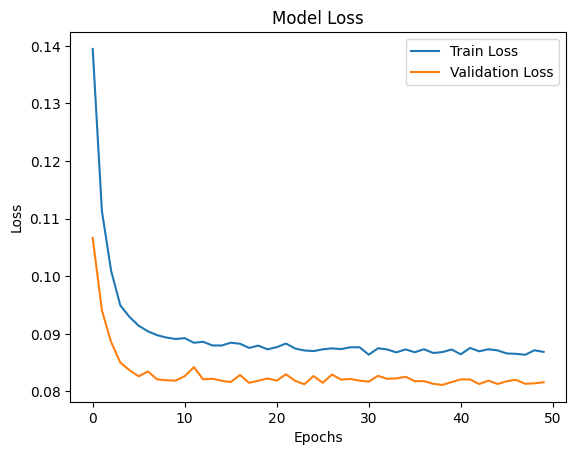

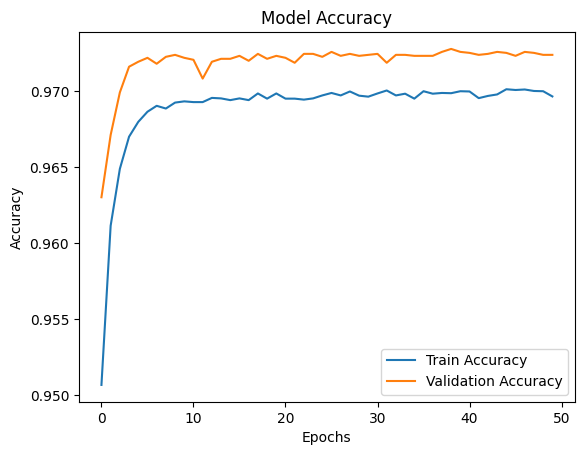

In [18]:
import matplotlib.pyplot as plt

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [19]:
# Prediction
y_pred = (model.predict(X_test) > 0.5).astype('int32')

# Classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

601/601 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     17509
           1       1.00      0.67      0.80      1721

    accuracy                           0.97     19230
   macro avg       0.98      0.84      0.89     19230
weighted avg       0.97      0.97      0.97     19230

